## IRF for different $(\delta, \lambda)$ under the speculative channel

The impulse response function (IRF) for price is defined as

$$
\mathbb E \left( P_{t+k} \mid R_t^a = \mu_R (1-\rho_R) + \rho_R R_{t-1}^a + \sigma_R \sqrt{1-\rho_R^2}, X_{t-1}, R_{t-1}^a \right)
    - \mathbb E \left(P_{t+k} \mid X_{t-1}, R_{t-1}^a \right),
\quad k = 0,1, \dots, K.
$$

We consider impulse responses in percentages when necessary. 
  
Since $\{R_t^a\}$ is a finite Markov chain, to represent the same shock to $\varepsilon_t^R$ for different $R_{t-1}^a$, we find the minimum state point of $\{R_t^a\}$ that is greater than or equal to $\mu_R (1-\rho_R) + \rho_R R_{t-1}^a + \sigma_R \sqrt{1-\rho_R^2}$. 

As long as the Tauchen discretizaion is sufficiently fine (e.g., a 500-state discretization), the resulting error should be minor. 

In [1]:
run pricing

In [2]:
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams["figure.autolayout"] = True

### Some global parameters

In [3]:
# Gaussian quadrature sample points and weights
gq_points, gq_weights = gauss_quadra()

# State points and prob trans matrix of {R_t}
μ_R = 1.006230606825128     # stationary mean of {R_t}
ρ_R = 0.9407262699728842    # autocor coef of {R_t}
σ_R = 0.030020587135876593  # stationary std dev of {R_t}
μ_R_adj = μ_R*(1-ρ_R)            # the intercept of the AR(1) process  
σ_R_adj = σ_R*np.sqrt(1-ρ_R**2)  # the std dev of the AR(1) innovation
Ra_vals, Π = build_dynamics(μ_R=μ_R_adj, ρ_R=ρ_R, σ_R=σ_R_adj, size=101)

# Size of MC samples & forwarding steps for IRF
size, periods = 100_000, 17 

# Solve the competitive storage model
cp = CommodityPricing(δ=0.02,
                      λ=0.1,
                      κ=0.0,
                      σ_Y=0.05,
                      Ra_vals=Ra_vals, Π=Π,
                      grid_size=100,
                      gq_points=gq_points,
                      gq_weights=gq_weights)
test_stability(cp, verbose=True)

# Number of MC and discarded samples to approx the stat dist of $(X_t,R_t)$
L, burn_in = 200_000, 50_000

# Simulate {R_t^a} indices process
mc = MarkovChain(cp.Π)
Ra_seq = mc.simulate(L+1, random_state=1234)

# Simulate {Y_t} process
Y_sim = truncnorm.rvs(a=-cp.trunc_Y,
                      b=cp.trunc_Y,
                      size=L+1,
                      loc=cp.μ_Y,
                      scale=cp.μ_Y * cp.σ_Y,
                      random_state=5678)

# Key parameters choices
λs = [0.03, 0.06, 0.09, 0.12, 0.15]
# λs = [0.04, 0.08, 0.12, 0.16, 0.20]
δs = [0.01, 0.02, 0.03, 0.04, 0.05]


TRUNCATED_NORMAL_RULE
  Python version: 3.10.14

  For the (truncated) Gaussian probability density function
    pdf(x) = exp(-0.5*((x-MU)/SIGMA)^2) / SIGMA / sqrt ( 2 * pi )
  compute an N-point quadrature rule for approximating
    Integral ( A <= x <= B ) f(x) pdf(x) dx

  The value of OPTION determines the truncation interval [A,B]:
  0: (-oo,+oo)
  1: [A,+oo)
  2: (-oo,B]
  3: [A,B]

  The user specifies OPTION, N, MU, SIGMA, A, B and FILENAME.

  HEADER is used to generate 3 files:

    header_w.txt - the weight file
    header_x.txt - the abscissa file.
    header_r.txt - the region file, listing A and B.

  OPTION = 3
  N = 7
  MU = 0
  SIGMA = 1
  A = -5
  B = 5
  HEADER = "gauss_quad"

  Creating quadrature files.

  Common header is      "gauss_quad".

  Weight file will be   "gauss_quad_w.txt".
  Abscissa file will be "gauss_quad_x.txt".
  Region file will be   "gauss_quad_r.txt".

TRUNCATED_NORMAL_RULE:
  Normal end of execution.

Stability condition holds: G < exp(δ).

G

### CIRF under different $(\delta, \lambda)$

In [4]:
def irf_param(δs, λs, X0_perc, Ra0_perc, shock):
    """
    IRF for different (δ, λ, X0_perc, Ra0_perc, shock) values.
    Multiple (δs, λs).
    """
    irf_P, irf_I, irf_ES = [np.empty((len(δs), len(λs))) for i in range(3)]
    for i, δ in enumerate(δs):
        for j, λ in enumerate(λs):
            impul_P, impul_I, _, _, impul_ES, _ = irf_vs_params(δ, λ, L, burn_in, 
                                                                shock, Ra0_perc, X0_perc,
                                                                Ra_vals, Π, Ra_seq, Y_sim, 
                                                                gq_points, gq_weights,
                                                                size=size, periods=1)
            irf_P[i,j], irf_I[i,j], irf_ES[i,j] = impul_P, impul_I, impul_ES
    return irf_P, irf_I, irf_ES

#### Case 1. Fix $(X_{t-1}, R_{t-1}^a)$ at the $(25\%, 75\%)$ percentiles

In [5]:
# Initial state
Ra0 = int(np.quantile(Ra_seq[burn_in+1:], 0.25))  # 25% percentile
X0 = 0.75  # 75% percentile

# A 100-bp interest rate shock (the impulses)
shock = find_next_Ra(cp, Ra0, shock=0.01 / σ_R_adj, 
                     μ_R=μ_R_adj, ρ_R=ρ_R, σ_R=σ_R_adj)

In [6]:
start = time.time()
irf_P, irf_I, irf_Pstd = irf_param(δs, λs, X0, Ra0, shock)
print(f'Time taken: {(time.time()-start)/60} minutes.')

# np.savez('../output/simulation_results/irf_param_R101_1.dat', 
#          R0=R0, X0=X0, shock=shock, λs=λs, δs=δs,
#          irf_P=irf_P, irf_I=irf_I, irf_Pstd=irf_Pstd)

Time taken: 69.14127164284388 minutes.


In [7]:
np.round(irf_P*100, 2)

array([[-2.63, -2.1 , -1.8 , -1.6 , -1.44],
       [-2.04, -1.54, -1.27, -1.08, -0.95],
       [-1.7 , -1.24, -0.99, -0.83, -0.72],
       [-1.46, -1.04, -0.82, -0.68, -0.58],
       [-1.28, -0.9 , -0.7 , -0.57, -0.48]])

In [8]:
np.round(irf_I*100, 2)

array([[-0.23, -0.49, -0.76, -1.02, -1.29],
       [-0.24, -0.5 , -0.76, -1.02, -1.28],
       [-0.25, -0.49, -0.74, -1.  , -1.26],
       [-0.25, -0.49, -0.74, -0.99, -1.25],
       [-0.25, -0.48, -0.73, -0.98, -1.25]])

In [9]:
np.round(irf_Pstd*100, 2)

array([[0.15, 1.6 , 2.58, 3.35, 4.  ],
       [0.81, 1.93, 2.62, 3.1 , 3.45],
       [0.9 , 1.71, 2.17, 2.44, 2.63],
       [0.88, 1.5 , 1.8 , 1.97, 2.08],
       [0.84, 1.31, 1.53, 1.65, 1.72]])

#### Case 2. Fix $(X_{t-1}, R_{t-1}^a)$ at the stationary mean

In [10]:
# Initial state
Ra0_2, X0_2 = int(mc.n/2), None

# A 100-bp interest rate shock (the impulses)
shock_2 = find_next_Ra(cp, Ra0_2, shock=0.01 / σ_R_adj, 
                       μ_R=μ_R_adj, ρ_R=ρ_R, σ_R=σ_R_adj)

In [11]:
start = time.time()
irf_P2, irf_I2, irf_Pstd2 = irf_param(δs, λs, X0_2, Ra0_2, shock_2)
print(f'Time taken: {(time.time()-start)/60} minutes.')

# np.savez('../output/simulation_results/irf_param_R101.dat', 
#          λs=λs, δs=δs, R0=R0, X0=X0, shock=shock, 
#          irf_P=irf_P, irf_I=irf_I, irf_Pstd=irf_Pstd,
#          R0_2=R0_2, X0_2=X0_2, shock_2=shock_2, 
#          irf_P2=irf_P2, irf_I2=irf_I2, irf_Pstd2=irf_Pstd2)

Time taken: 71.24977996349335 minutes.


In [12]:
np.round(irf_P2*100, 2)

array([[-2.12, -1.63, -1.36, -1.18, -1.04],
       [-1.58, -1.16, -0.93, -0.78, -0.67],
       [-1.28, -0.91, -0.71, -0.59, -0.49],
       [-1.09, -0.75, -0.58, -0.46, -0.39],
       [-0.94, -0.64, -0.48, -0.39, -0.32]])

In [13]:
np.round(irf_I2*100, 2)

array([[-0.27, -0.56, -0.85, -1.14, -1.44],
       [-0.29, -0.58, -0.87, -1.16, -1.45],
       [-0.3 , -0.58, -0.86, -1.16, -1.45],
       [-0.3 , -0.57, -0.86, -1.15, -1.46],
       [-0.3 , -0.57, -0.85, -1.15, -1.44]])

In [14]:
np.round(irf_Pstd2*100, 2)

array([[0.97, 2.27, 3.08, 3.64, 4.05],
       [1.14, 1.91, 2.3 , 2.55, 2.71],
       [1.05, 1.54, 1.77, 1.91, 2.01],
       [0.94, 1.28, 1.44, 1.53, 1.62],
       [0.84, 1.09, 1.2 , 1.3 , 1.33]])

In [15]:
irf_P

array([[-0.02625345, -0.0210232 , -0.01799996, -0.01596116, -0.01444155],
       [-0.02041468, -0.0154447 , -0.01265783, -0.01084529, -0.00950552],
       [-0.01695421, -0.01242006, -0.00991491, -0.00831196, -0.00719255],
       [-0.01456934, -0.01043295, -0.00821294, -0.00677836, -0.00577191],
       [-0.01281479, -0.00901437, -0.00699451, -0.0057269 , -0.00478374]])

In [16]:
irf_P/irf_P2

array([[1.24037816, 1.28837819, 1.32469752, 1.35675838, 1.38473496],
       [1.29096617, 1.33088215, 1.36162337, 1.39664774, 1.4203201 ],
       [1.32031003, 1.35762956, 1.39460013, 1.42078658, 1.46907354],
       [1.34234875, 1.38873243, 1.41808232, 1.47050078, 1.48094319],
       [1.36139978, 1.40153683, 1.46198526, 1.47984679, 1.49429169]])

### IRF (multi-periods) 

In [17]:
def irf_param_H(δs, λs, X0_perc, Ra0_perc, shock, periods=17):
    """
    IRF for different (δs, λs, X0_perc, Ra0_perc, shock, periods) values.
    Multiple (δs, λs).
    """
    irf_P, irf_I, irf_ES = [np.empty((periods,len(δs),len(λs))) for i in range(3)]
    for i, δ in enumerate(δs):
        for j, λ in enumerate(λs):
            impul_P, impul_I, _, _, impul_ES, _ = irf_vs_params(δ, λ, L, burn_in, 
                                                                shock, Ra0_perc, X0_perc,
                                                                Ra_vals, Π, Ra_seq, Y_sim, 
                                                                gq_points, gq_weights,
                                                                size=size, periods=periods)
            irf_P[:,i,j], irf_I[:,i,j], irf_ES[:,i,j] = impul_P, impul_I, impul_ES
    return irf_P, irf_I, irf_ES

In [18]:
Ra0_perc, X0_perc = 50, None

# A 100-BP interest rate shock (the impulse)
shocks = find_next_Ra(cp, Ra0_perc, shock=0.01 / σ_R_adj,
                      μ_R=μ_R_adj, ρ_R=ρ_R, σ_R=σ_R_adj)

#### IRF vs $\delta$

Fix the demand elasticity $\lambda=-0.06$

In [19]:
λ_set = [0.06]
irf_PH, irf_IH, irf_PstdH = irf_param_H(δs, λ_set, X0_perc, Ra0_perc, shocks)
irf_PH, irf_IH, irf_PstdH = irf_PH[:,:,0], irf_IH[:,:,0], irf_PstdH[:,:,0]

#### IRF vs $\lambda$

Fix depreciation rate $\delta=0.02$

In [20]:
δ_set = [0.02]
irf_PH_λ, irf_IH_λ, irf_PstdH_λ = irf_param_H(δ_set, λs, X0_perc, Ra0_perc, shocks)
irf_PH_λ, irf_IH_λ, irf_PstdH_λ = irf_PH_λ[:,0,:], irf_IH_λ[:,0,:], irf_PstdH_λ[:,0,:]

#### IRF conditional on the $(75\%,25\%)$ percentile of $(X_{t-1},R_{t-1}^a)$

In [21]:
Ra0_perc, X0_perc = int(np.quantile(Ra_seq[burn_in+1:], 0.25)), 0.75  # (25%,75%) percentile

# A 100-BP interest rate shock (the impulse)
shocks = find_next_Ra(cp, Ra0_perc, shock=0.01 / σ_R_adj,
                      μ_R=μ_R_adj, ρ_R=ρ_R, σ_R=σ_R_adj)

irf_PH2, irf_IH2, irf_PstdH2 = irf_param_H(δs, λ_set, X0_perc, Ra0_perc, shocks)
irf_PH2, irf_IH2, irf_PstdH2 = irf_PH2[:,:,0], irf_IH2[:,:,0], irf_PstdH2[:,:,0]

irf_PH_λ2, irf_IH_λ2, irf_PstdH_λ2 = irf_param_H(δ_set, λs, X0_perc, Ra0_perc, shocks)
irf_PH_λ2, irf_IH_λ2, irf_PstdH_λ2 = irf_PH_λ2[:,0,:], irf_IH_λ2[:,0,:], irf_PstdH_λ2[:,0,:]

In [22]:
(irf_IH2/irf_IH).max(), (irf_IH_λ2/irf_IH_λ).max()

(1.1634086088570021, 1.1850400889360893)

In [23]:
(irf_PstdH2/irf_PstdH).max(), (irf_PstdH_λ2/irf_PstdH_λ).max()

(1.237261411490303, 1.3027381666097917)

#### IRF plot

In [24]:
# dat = np.load('../output/simulation_results/irf_param.dat.npz')
# irf_PH = dat['irf_PH'] 
# irf_IH = dat['irf_IH'] 
# irf_PstdH = dat['irf_PstdH']
# irf_PH_λ = dat['irf_PH_λ']
# irf_IH_λ = dat['irf_IH_λ'] 
# irf_PstdH_λ = dat['irf_PstdH_λ']
# λ_set = [0.06]
# δ_set = [0.02]

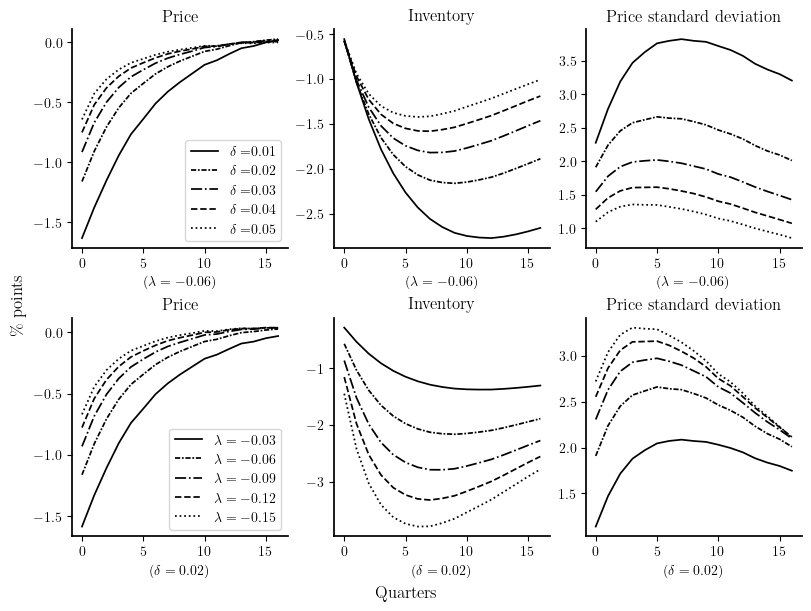

In [25]:
fig, axes = plt.subplots(2,3, figsize=(8,6), layout='constrained', 
                         gridspec_kw={'width_ratios': [5,5,5]})
fig.set_constrained_layout_pads(w_pad=3./72., h_pad=3./72.)
irf_set1 = [irf_PH, irf_IH, irf_PstdH]
irf_set2 = [irf_PH_λ, irf_IH_λ, irf_PstdH_λ]
irf_sets = [irf_set1, irf_set2]
lss = ['-', (0,(3,1,1,1)), '-.', '--', ':']
titles = ['Price', 'Inventory', 'Price standard deviation']
lw = 1.25

for k in range(len(irf_sets)):
    for j in range(len(irf_set1)):
        ax = axes[k,j]
        ax.spines['left'].set_linewidth(1.25)
        ax.spines['bottom'].set_linewidth(1.25)
        ax.set_title(titles[j], fontweight='bold')
        ax.set_xticks([0,5,10,15])
        if k == 0:
            for i, δ in enumerate(δs):
                ax.plot(irf_sets[k][j][:,i]*100, ls=lss[i], c='black', lw=lw, label=f'$\\delta=${δ}')
                ax.set_xlabel(f'($\lambda=-{λ_set[0]}$)')
                if j == 0:
                    ax.legend()
        else:
            for i, λ in enumerate(λs):
                ax.plot(irf_sets[k][j][:,i]*100, ls=lss[i], c='black', lw=lw, label=f'$\lambda=-${λ:.2f}')
                ax.set_xlabel(f'($\delta={δ_set[0]}$)')
                if j == 0:
                    ax.legend()
fig.supxlabel('Quarters')
fig.supylabel('$\%$ points')
plt.savefig('../output/figures/irf_param_Xpast_mean.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [27]:
# np.savez('../output/simulation_results/irf_param.dat',
#          irf_PH=irf_PH, irf_IH=irf_IH, irf_PstdH=irf_PstdH,
#          irf_PH_λ=irf_PH_λ, irf_IH_λ=irf_IH_λ, irf_PstdH_λ=irf_PstdH_λ,
#          irf_PH2=irf_PH2, irf_IH2=irf_IH2, irf_PstdH2=irf_PstdH2,
#          irf_PH_λ2=irf_PH_λ2, irf_IH_λ2=irf_IH_λ2, irf_PstdH_λ2=irf_PstdH_λ2)